### 데이터 불러오기

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose([transforms.Resize(34),
                                transforms.CenterCrop(28),
                                transforms.RandomHorizontalFlip(),
                                transforms.Lambda(lambda x: x.rotate(90)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 데이터 일부 확인

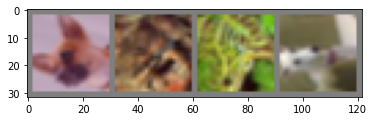

dog   frog  frog  dog  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
print(trainset.__getitem__(0)[0].size())


torch.Size([3, 28, 28])


## 모델 정의
이후부터 과제 진행하시면 됩니다! 위는 수정 XX

'#####으로 표시된 부분에 작성하세요!

In [ ]:
import torch.nn as nn

In [ ]:
# conv. layer, relu,  pooling layer, fc layer를 모두 1층 이상 사용하는 모델 Net()을 만들어주세요

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3),             # kernel size는 filter size이다.
            nn.BatchNorm2d(16),                                                 # 위 코드의 결과값을 정규화
            nn.ReLU(),                                                          # {3,28,28} => {16,26,26}              
            nn.Conv2d(in_channels=16,out_channels=48,kernel_size=3),            # {16,26,26} => {48,24,24}
            nn.BatchNorm2d(48),
            nn.ReLU(),                                                          
            nn.MaxPool2d(kernel_size=2,stride=2),                               # {48,24,24} => {48,12,12}
            nn.Conv2d(in_channels=48, out_channels=72, kernel_size=3),          # {48,12,12} => {72,10,10}     
            nn.BatchNorm2d(72),   
            nn.ReLU(),  
            nn.MaxPool2d(kernel_size=2,stride=2)                                # {72,10,10} => {72,5,5}                                
            )
        self.fc_layer = nn.Sequential(                                          
            nn.Linear(72*5*5,100),  
            nn.BatchNorm1d(100),                                           
            nn.ReLU(),
            nn.Linear(100,10)                                                   
            )       
    def forward(self, x):
      out = self.layer(x)                                                    
      out = out.view(out.size(0),-1)                                          
      out = self.fc_layer(out)
      return out

net = Net()

## 손실함수, optimizer 정의
필요한 모듈을 import하고 손실함수는 CrossEntropyLoss, optimizer는 SGD를 사용해주세요.

optimizer의 하이퍼파라미터는 lr=0.001, momentum=0.9로 통일합니다.

작성한 모델이 무거워 실행 시간이 오래 걸린다면 GPU를 활용하세요.

In [ ]:
import torch.optim as optim
device=torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')  
model=Net().to(device)
loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(), momentum = 0.9, lr=0.001)

## 모델 구조 확인
필요한 모듈을 import하여 모델의 구조를 확인하세요.

In [ ]:
!pip install torchsummary

In [ ]:
from torchsummary import summary
summary(model, (3,28,28), batch_size=256)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [256, 16, 26, 26]             448
       BatchNorm2d-2          [256, 16, 26, 26]              32
              ReLU-3          [256, 16, 26, 26]               0
            Conv2d-4          [256, 48, 24, 24]           6,960
       BatchNorm2d-5          [256, 48, 24, 24]              96
              ReLU-6          [256, 48, 24, 24]               0
         MaxPool2d-7          [256, 48, 12, 12]               0
            Conv2d-8          [256, 72, 10, 10]          31,176
       BatchNorm2d-9          [256, 72, 10, 10]             144
             ReLU-10          [256, 72, 10, 10]               0
        MaxPool2d-11            [256, 72, 5, 5]               0
           Linear-12                 [256, 100]         180,100
      BatchNorm1d-13                 [256, 100]             200
             ReLU-14                 [2

## Train

In [ ]:
# 모델을 학습

for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data     
        x_ = inputs.to(device)
        y_ = labels.to(device)
        optimizer.zero_grad()
        output = model.forward(x_)  
        loss=loss_func(output,y_)     
        loss.backward()               
        optimizer.step()              

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.892
[1,  4000] loss: 1.710
[1,  6000] loss: 1.682
[1,  8000] loss: 1.582
[1, 10000] loss: 1.566
[1, 12000] loss: 1.521
[2,  2000] loss: 1.456
[2,  4000] loss: 1.453
[2,  6000] loss: 1.418
[2,  8000] loss: 1.415
[2, 10000] loss: 1.393
[2, 12000] loss: 1.378
Finished Training


## Test

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

In [ ]:
## 아래 코드 그대로 실행

correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = model(images.to(device))
        outputs.cpu()
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().float()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 62.0 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


## 클래스별 accuracy 비교

In [ ]:
## 아래 코드 그대로 실행

# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions.cpu()):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 71.5 %
Accuracy for class: car   is 75.1 %
Accuracy for class: bird  is 46.7 %
Accuracy for class: cat   is 42.5 %
Accuracy for class: deer  is 40.7 %
Accuracy for class: dog   is 58.2 %
Accuracy for class: frog  is 72.4 %
Accuracy for class: horse is 67.3 %
Accuracy for class: ship  is 75.9 %
Accuracy for class: truck is 70.8 %
